In [2]:
import sys

sys.path.append("../")

import MetaTrader5 as mt5
import pytz
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from datetime import datetime, timedelta
from terminal.Extensions.MT5 import MT5
from terminal.Extensions.Range import Range

In [3]:
MT5.initialize()

In [4]:
from_date = datetime(2024, 6, 19, hour=6, tzinfo=pytz.utc)
to_date = datetime(2024, 6, 20, tzinfo=pytz.utc)

trades_list = None

while from_date < to_date:
    trades = mt5.copy_ticks_range(
        "WDON24", from_date, from_date.replace(hour=23), mt5.COPY_TICKS_TRADE
    )
    if mt5.last_error()[0] == mt5.RES_S_OK and len(trades.shape) == 1:
        if trades_list is None:
            trades_list = trades
        else:
            trades_list = np.append(trades_list, trades)
    from_date += timedelta(days=1)
    del trades

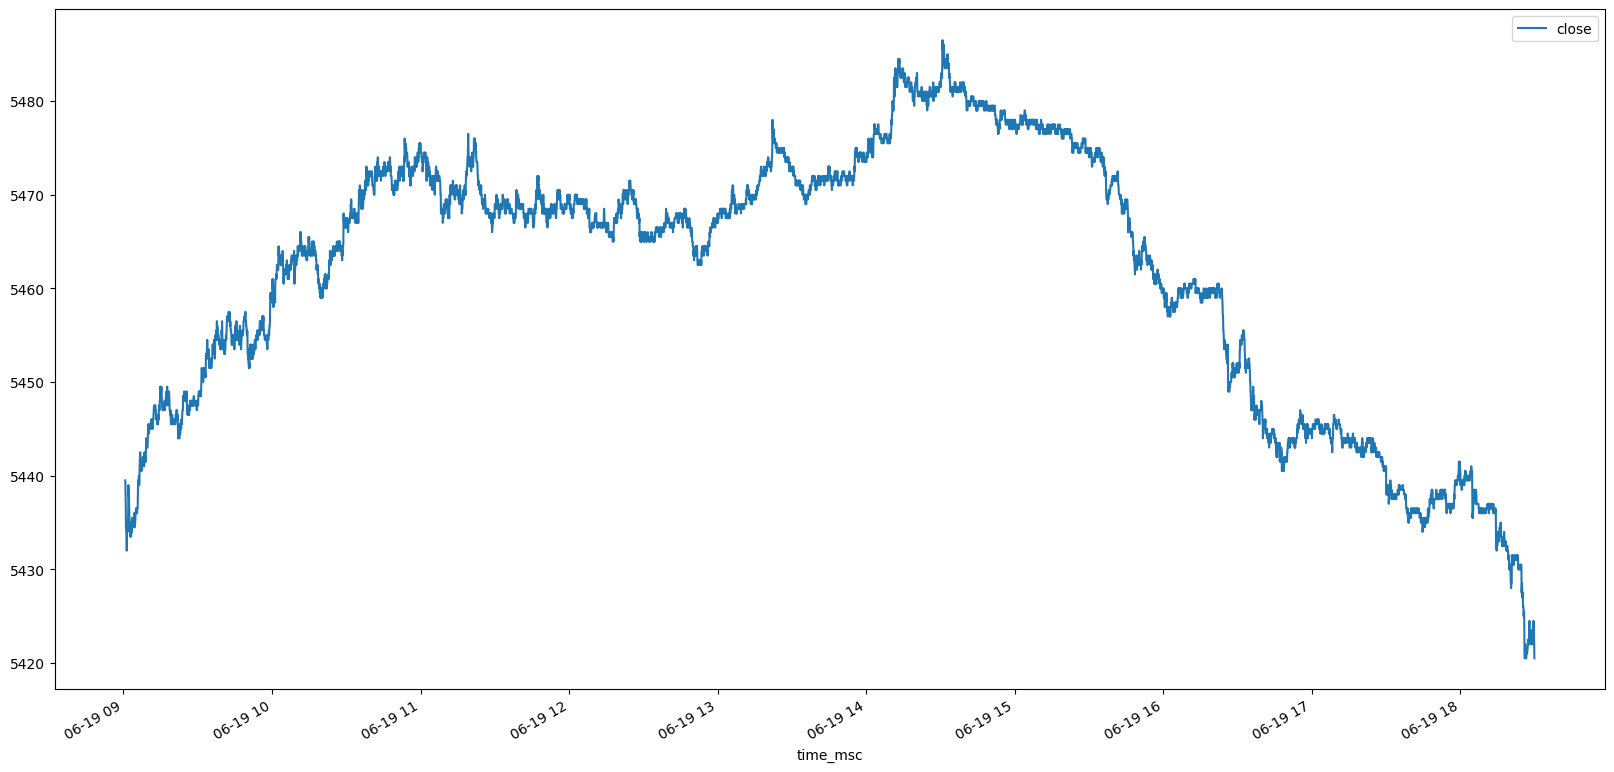

In [9]:
ohlc = MT5.create_ohlc_from_ticks(trades_list, "5s")

ohlc.loc[(ohlc["open"] < ohlc["close"]), "type"] = "up"
ohlc.loc[(ohlc["open"] > ohlc["close"]), "type"] = "down"

ohlc["type"] = ohlc["type"].shift(1)
ohlc[["close"]].plot(figsize=(20, 10), subplots=[("close",),])
ohlc.to_excel("bricks.xlsx")

In [10]:
def plot_chart():
    fig = go.Figure(
        data=go.Ohlc(
            open=ohlc["open"],
            high=ohlc["high"],
            low=ohlc["low"],
            close=ohlc["close"],
        )
    )

    fig.update(layout_xaxis_rangeslider_visible=False)

    fig.update_layout(
        autosize=True,
        width=1500,
        height=600,
    )

    return fig


plot_chart()

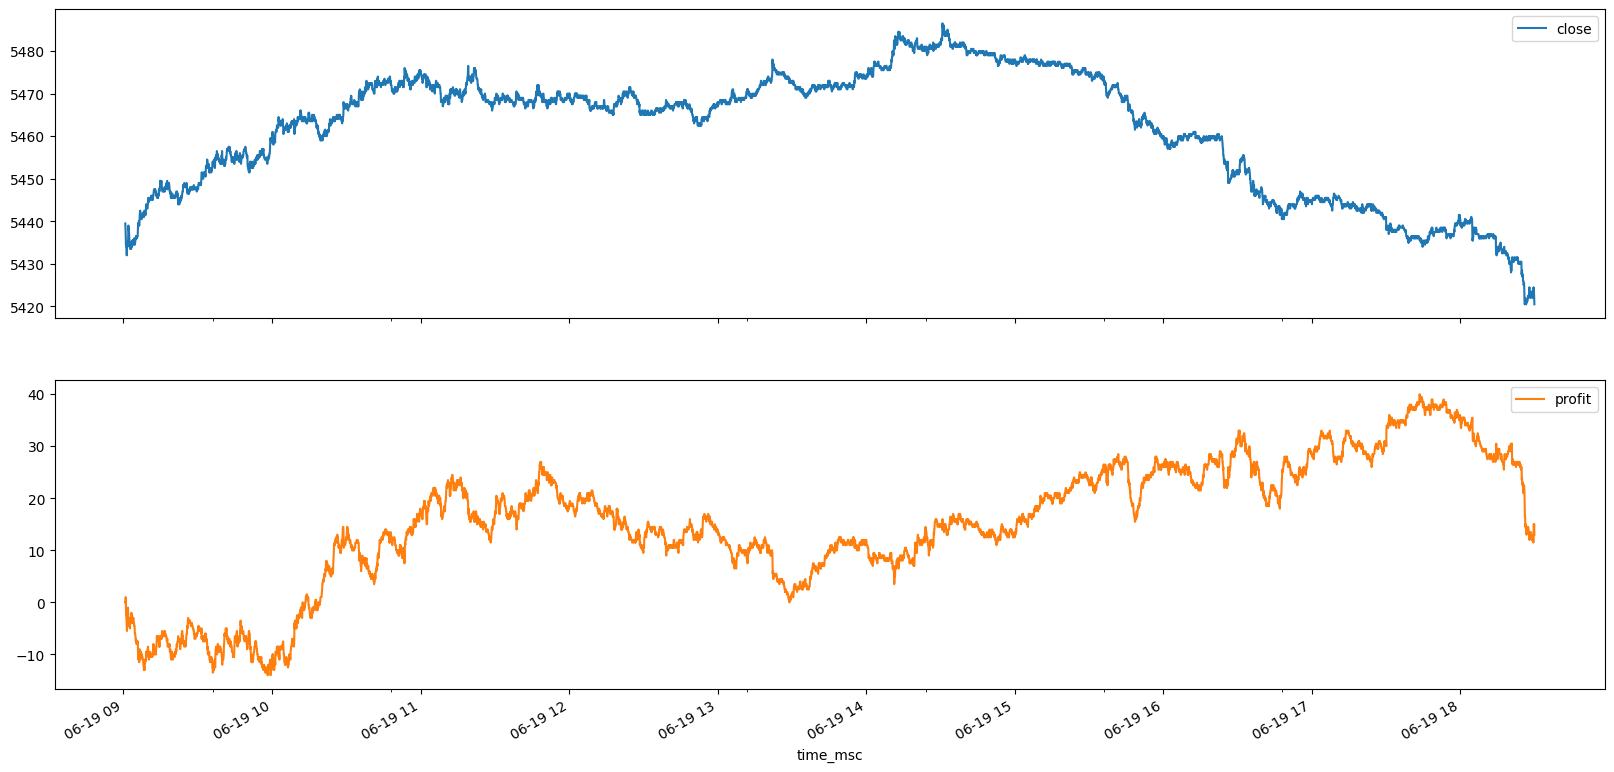

In [11]:
temp = ohlc.copy()

temp["position_side"] = np.nan
temp["position"] = np.nan
temp["profit"] = np.nan

position_side = 0  # 1 = BUY, -1 = SELL

for i, item in temp.iterrows():
    if position_side == 0 and item["type"] == "down":  # buy
        temp.loc[i, "position"] = item["open"] * -1
        position_side = 1
    elif position_side == 0 and item["type"] == "up":  # sell
        temp.loc[i, "position"] = item["open"]
        position_side = -1
    elif position_side == -1 and item["type"] == "down":  # invert sell
        temp.loc[i, "position"] = item["open"] * 2 * -1
        position_side = 1
    elif position_side == 1 and item["type"] == "up":  # invert buy
        temp.loc[i, "position"] = item["open"] * 2
        position_side = -1

    temp.loc[i, "position_side"] = position_side
    temp.loc[i, "profit"] = temp.loc[:i]["position"].sum()

    if position_side == 1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "open"] * -1
    elif position_side == -1:
        temp.loc[i, "profit"] = temp.loc[i, "profit"] - temp.loc[i, "open"]

temp[["close", "profit"]].plot(figsize=(20, 10), subplots=[("close",), ("profit",)])
temp.to_excel("bricks.xlsx")